## Movielens

Unofficial lecture notes
- http://forums.fast.ai/t/deeplearning-lecnotes5/8416
- http://forums.fast.ai/t/deeplearning-lecnotes6/8641
- https://medium.com/@hiromi_suenaga/deep-learning-2-part-1-lesson-5-dd904506bee8
- https://medium.com/@hiromi_suenaga/deep-learning-2-part-1-lesson-6-de70d626976c

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *

Data available from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

In [4]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip -P data
!unzip data/ml-latest-small.zip -d data

--2018-03-05 13:23:48--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.34.235
Connecting to files.grouplens.org (files.grouplens.org)|128.101.34.235|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 918269 (897K) [application/zip]
Saving to: ‘data/ml-latest-small.zip.1’

ml-latest-small.zip 100%[===================>] 896.75K  5.16MB/s    in 0.2s    

2018-03-05 13:23:48 (5.16 MB/s) - ‘data/ml-latest-small.zip.1’ saved [918269/918269]

Archive:  data/ml-latest-small.zip
   creating: data/ml-latest-small/
  inflating: data/ml-latest-small/links.csv  
  inflating: data/ml-latest-small/movies.csv  
  inflating: data/ml-latest-small/ratings.csv  
  inflating: data/ml-latest-small/README.txt  
  inflating: data/ml-latest-small/tags.csv  


In [2]:
!ls data/ml-latest-small/

links.csv  models  movies.csv  ratings.csv  README.txt	tags.csv  tmp


In [3]:
path='data/ml-latest-small/'

We're working with the movielens data, which contains one rating per row, like this:

In [4]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Just for display purposes, let's read in the movie names too.

In [5]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [6]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15] # pandas.core.series.Series: userId(index), count

g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,110,260,296,318,356,480,527,589,593,608,1196,1198,1270,2571
userId,,,,,,,,,,,,,,,
15,2.0,3.0,5.0,5.0,2.0,1.0,3.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0
30,4.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,3.0
73,5.0,4.0,4.5,5.0,5.0,5.0,4.0,5.0,3.0,4.5,4.0,5.0,5.0,5.0,4.5
212,3.0,5.0,4.0,4.0,4.5,4.0,3.0,5.0,3.0,4.0,NaN,NaN,3.0,3.0,5.0
213,3.0,2.5,5.0,NaN,NaN,2.0,5.0,NaN,4.0,2.5,2.0,5.0,3.0,3.0,4.0
294,4.0,3.0,4.0,NaN,3.0,4.0,4.0,4.0,3.0,NaN,NaN,4.0,4.5,4.0,4.5
311,3.0,3.0,4.0,3.0,4.5,5.0,4.5,5.0,4.5,2.0,4.0,3.0,4.5,4.5,4.0
380,4.0,5.0,4.0,5.0,4.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,NaN,3.0,5.0
452,3.5,4.0,4.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,2.0


In [7]:
len(ratings), len(top_r)

(100004, 206)

In [8]:
top_r.head()

,userId,movieId,rating,timestamp,rating_r,rating_r
962,15,1,2.0,997938310,1700,247
5048,30,1,4.0,944943070,1011,247
10214,73,1,5.0,1303464840,1610,247
28390,212,1,3.0,1218405007,876,247
29266,213,1,3.0,1462637445,910,247


## Collaborative filtering

In [9]:
val_idxs = get_cv_idxs(len(ratings)) # len(ratings)=100004, len(val_idxs)=20000
wd=2e-4 # L2 regularization (weight decay)
n_factors = 50 # embedding sizes

#def get_cv_idxs(n, cv_idx=0, val_pct=0.2, seed=42):
#    np.random.seed(seed)
#    n_val = int(val_pct*n)
#    idx_start = cv_idx*n_val
#    idxs = np.random.permutation(n)
#    return idxs[idx_start:idx_start+n_val]

In [10]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam) # 64: batch size

In [11]:
learn

EmbeddingDotBias(
  (u): Embedding(671, 50)
  (i): Embedding(9066, 50)
  (ub): Embedding(671, 1)
  (ib): Embedding(9066, 1)
)

In [11]:
learn.fit(1e-2, 2, wds=wd, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.836414   0.807579  
    1      0.781512   0.775135                                  
    2      0.616327   0.762754                                  



[0.76275355]

Let's compare to some benchmarks. Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on [RMSE](http://www.statisticshowto.com/rmse/) of 0.91. We'll need to take the square root of our loss, since we use plain MSE.

In [12]:
math.sqrt(0.776)

0.8809086218218096

Looking good - we've found a solution better than any of those benchmarks! Let's take a look at how the predictions compare to actuals for this model.

In [13]:
preds = learn.predict() # (20000,)

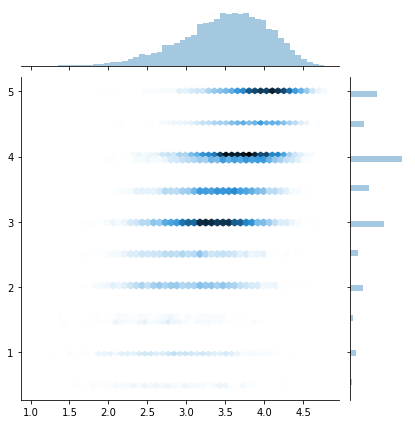

In [14]:
y=learn.data.val_y
sns.jointplot(preds, y, kind='hex', stat_func=None); # https://seaborn.pydata.org/generated/seaborn.jointplot.html

## Analyze results

### Movie bias

In [15]:
movie_names = movies.set_index('movieId')['title'].to_dict()
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False).index.values[:3000]
topMovieIdx = np.array([cf.item2idx[o] for o in topMovies])

In [16]:
m=learn.model; m.cuda() # fastai.column_data.EmbeddingDotBias

#class EmbeddingDotBias(nn.Module):
#    def __init__(self, n_factors, n_users, n_items, min_score, max_score):
#        super().__init__()
#        self.min_score,self.max_score = min_score,max_score
#        (self.u, self.i, self.ub, self.ib) = [get_emb(*o) for o in [
#            (n_users, n_factors), (n_items, n_factors), (n_users,1), (n_items,1)
#        ]]

EmbeddingDotBias(
  (u): Embedding(671, 50)
  (i): Embedding(9066, 50)
  (ub): Embedding(671, 1)
  (ib): Embedding(9066, 1)
)

First, we'll look at the movie bias term. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [17]:
movie_bias = to_np(m.ib(V(topMovieIdx))) # m.ib() returns torch.autograd.variable.Variable, 'ib' is abbreviation of 'item bias'

#def V(x, requires_grad=False):
#    return [V_(o, requires_grad) for o in x] if isinstance(x,list) else V_(x, requires_grad)
#File:      ~/fastai/courses/dl1/fastai/core.py

In [18]:
movie_bias

array([[0.79015],
       [0.86813],
       [1.26569],
       ...,
       [0.37268],
       [0.03053],
       [0.22432]], dtype=float32)

In [21]:
movie_ratings = [(b[0], movie_names[i]) for i,b in zip(topMovies,movie_bias)] # b: (1,)

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [22]:
sorted(movie_ratings, key=lambda o: o[0])[:15]

[(-0.9611261, 'Battlefield Earth (2000)'),
 (-0.73671484, 'Wild Wild West (1999)'),
 (-0.734513, 'Anaconda (1997)'),
 (-0.69707024, 'Speed 2: Cruise Control (1997)'),
 (-0.6680587, 'Super Mario Bros. (1993)'),
 (-0.6646527, 'Haunting, The (1999)'),
 (-0.6544861, 'Batman & Robin (1997)'),
 (-0.6543728, 'Hollow Man (2000)'),
 (-0.6209498, 'Superman III (1983)'),
 (-0.6200627, 'Inspector Gadget (1999)'),
 (-0.6130361, "Joe's Apartment (1996)"),
 (-0.610432, 'Police Academy 6: City Under Siege (1989)'),
 (-0.6077866, 'Flintstones, The (1994)'),
 (-0.60767716, 'Congo (1995)'),
 (-0.6014493, 'Mighty Morphin Power Rangers: The Movie (1995)')]

In [23]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.9611261, 'Battlefield Earth (2000)'),
 (-0.73671484, 'Wild Wild West (1999)'),
 (-0.734513, 'Anaconda (1997)'),
 (-0.69707024, 'Speed 2: Cruise Control (1997)'),
 (-0.6680587, 'Super Mario Bros. (1993)'),
 (-0.6646527, 'Haunting, The (1999)'),
 (-0.6544861, 'Batman & Robin (1997)'),
 (-0.6543728, 'Hollow Man (2000)'),
 (-0.6209498, 'Superman III (1983)'),
 (-0.6200627, 'Inspector Gadget (1999)'),
 (-0.6130361, "Joe's Apartment (1996)"),
 (-0.610432, 'Police Academy 6: City Under Siege (1989)'),
 (-0.6077866, 'Flintstones, The (1994)'),
 (-0.60767716, 'Congo (1995)'),
 (-0.6014493, 'Mighty Morphin Power Rangers: The Movie (1995)')]

In [24]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(1.2656864, 'Shawshank Redemption, The (1994)'),
 (1.1540446, 'Godfather, The (1972)'),
 (1.0630186, 'Usual Suspects, The (1995)'),
 (1.0335481, "Schindler's List (1993)"),
 (0.91479963, 'Godfather: Part II, The (1974)'),
 (0.8967583, 'Matrix, The (1999)'),
 (0.8852744, '12 Angry Men (1957)'),
 (0.8761475, 'To Kill a Mockingbird (1962)'),
 (0.87001425, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (0.868134, 'Pulp Fiction (1994)'),
 (0.8649512, 'Princess Bride, The (1987)'),
 (0.8520138, 'Fargo (1996)'),
 (0.84087974, 'North by Northwest (1959)'),
 (0.8395586, 'Star Wars: Episode IV - A New Hope (1977)'),
 (0.8355266, 'Casablanca (1942)')]

### Embedding interpretation

We can now do the same thing for the embeddings.

In [25]:
movie_emb = to_np(m.i(V(topMovieIdx))) # 'i' is abbreviation of 'items'
movie_emb.shape # (len(topMovies), n_factors)

(3000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [27]:
movie_pca.shape

(3, 3000)

In [28]:
fac0 = movie_pca[0]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'easy watching' vs 'serious'.

In [29]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.07470648, 'Being John Malkovich (1999)'),
 (0.07463487, 'Pulp Fiction (1994)'),
 (0.068173654, "One Flew Over the Cuckoo's Nest (1975)"),
 (0.066246055, '2001: A Space Odyssey (1968)'),
 (0.06606271, 'Apocalypse Now (1979)'),
 (0.06395689, 'Fargo (1996)'),
 (0.061581727, 'Trainspotting (1996)'),
 (0.061505996, 'Memento (2000)'),
 (0.059241533, 'Goodfellas (1990)'),
 (0.05921165, 'Brokeback Mountain (2005)')]

In [30]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.08010012, 'Independence Day (a.k.a. ID4) (1996)'),
 (-0.07215151, 'Armageddon (1998)'),
 (-0.062264252, "Charlie's Angels (2000)"),
 (-0.059344843, 'Ace Ventura: When Nature Calls (1995)'),
 (-0.056406017, 'Con Air (1997)'),
 (-0.05627635, 'X-Men (2000)'),
 (-0.05384413, 'Pay It Forward (2000)'),
 (-0.053409833, 'Casper (1995)'),
 (-0.05248477, 'Titanic (1997)'),
 (-0.05243469, 'Pearl Harbor (2001)')]

In [31]:
fac1 = movie_pca[1]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac1, topMovies)]

Here's the 2nd component. It seems to be 'CGI' vs 'dialog driven'.

In [32]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.108247384, 'Lord of the Rings: The Two Towers, The (2002)'),
 (0.1040899, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (0.10048841, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (0.10041688, 'Star Wars: Episode IV - A New Hope (1977)'),
 (0.096779615, 'Lord of the Rings: The Return of the King, The (2003)'),
 (0.09274966, 'Sixth Sense, The (1999)'),
 (0.09248036, 'Dark Knight, The (2008)'),
 (0.088429086, 'Spider-Man (2002)'),
 (0.08839247, 'Lethal Weapon (1987)'),
 (0.085219, 'X-Men (2000)')]

In [33]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.059982043, 'Tank Girl (1995)'),
 (-0.058793277, 'Bringing Up Baby (1938)'),
 (-0.05170394, "Charlie's Angels: Full Throttle (2003)"),
 (-0.048474055, 'Piano, The (1993)'),
 (-0.045873165, 'Battlefield Earth (2000)'),
 (-0.044813737, 'Anaconda (1997)'),
 (-0.044464666, 'Catwoman (2004)'),
 (-0.04404136, 'Bowfinger (1999)'),
 (-0.04403061, 'Alien: Resurrection (1997)'),
 (-0.043623578, 'Mission to Mars (2000)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the first two components.

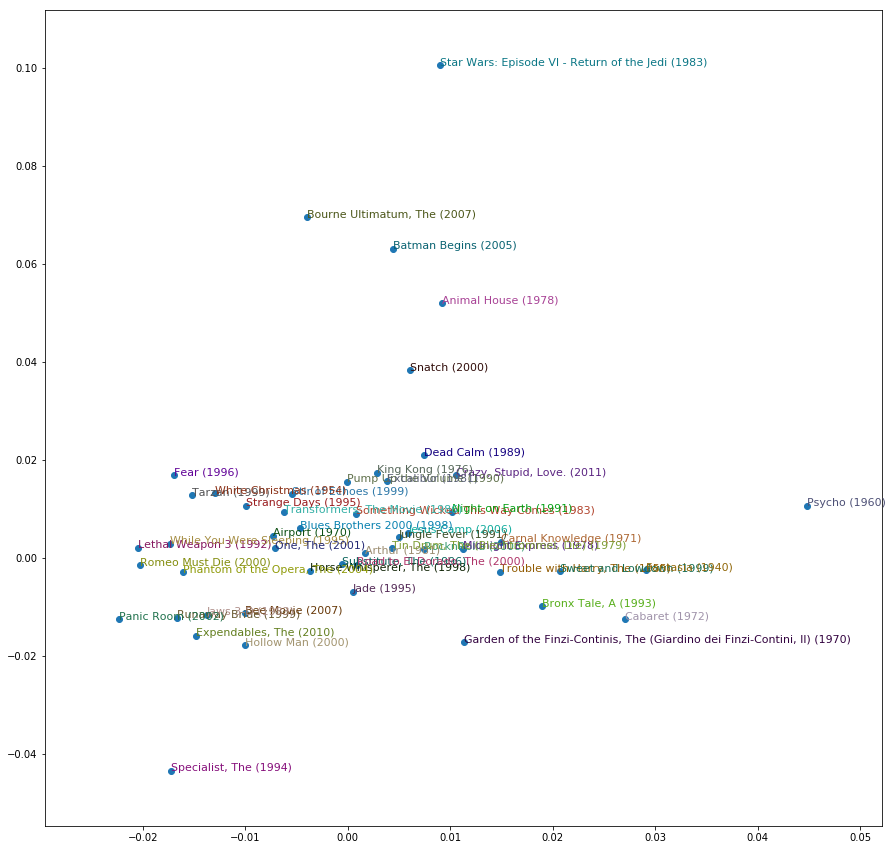

In [34]:
idxs = np.random.choice(len(topMovies), 50, replace=False)
X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[idxs], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

## Collab filtering from scratch

### Dot product example

In [35]:
a = T([[1.,2],[3,4]])
b = T([[2.,2],[10,10]])
a,b

(
  1  2
  3  4
 [torch.cuda.FloatTensor of size 2x2 (GPU 0)], 
   2   2
  10  10
 [torch.cuda.FloatTensor of size 2x2 (GPU 0)])

In [36]:
a*b # elementwise product


  2   4
 30  40
[torch.cuda.FloatTensor of size 2x2 (GPU 0)]

In [37]:
(a*b).sum(1) # 1: dimension


  6
 70
[torch.cuda.FloatTensor of size 2 (GPU 0)]

In [38]:
class DotProduct(nn.Module):
    def forward(self, u, m): return (u*m).sum(1)

In [39]:
model=DotProduct()

In [40]:
model(a,b) # apply inner dot product for each row vectors


  6
 70
[torch.cuda.FloatTensor of size 2 (GPU 0)]

### Dot product model

In [41]:
u_uniq = ratings.userId.unique()
user2idx = {o:i for i,o in enumerate(u_uniq)} # 0 ~ u_uniq-1
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

m_uniq = ratings.movieId.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)} # 0 ~ m_uniq-1
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

n_users=int(ratings.userId.nunique())
n_movies=int(ratings.movieId.nunique())

In [42]:
class EmbeddingDot(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.u.weight.data.uniform_(0,0.05)
        self.m.weight.data.uniform_(0,0.05)
        
    def forward(self, cats, conts): # conts: continuous variables?
        users,movies = cats[:,0],cats[:,1]
        u,m = self.u(users),self.m(movies)
        return (u*m).sum(1)

In [43]:
x = ratings.drop(['rating', 'timestamp'],axis=1)
y = ratings['rating'].astype(np.float32)

In [44]:
x.head()

,userId,movieId
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4


In [45]:
y.head()

0    2.5
1    3.0
2    3.0
3    2.0
4    4.0
Name: rating, dtype: float32

In [46]:
#  x: data frame
#  y: target 
#  ['userId, 'moveId']: category fields
# 64: batch size
data = ColumnarModelData.from_data_frame(path, val_idxs, x, y, ['userId', 'movieId'], 64)

In [47]:
wd=1e-5
model = EmbeddingDot(n_users, n_movies).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [48]:
fit(model, data, 3, opt, F.mse_loss) # fit() is defined in ~/fastai/courses/dl1/fastai/model.py

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                 
    0      1.637761   1.650456  
    1      1.133879   1.296729                                 
    2      0.897072   1.228169                                  



[1.2281692]

In [55]:
data.trn_ds[:5] # [cats, conts, y]

[array([[0, 0],
        [0, 1],
        [0, 2],
        [0, 3],
        [0, 4]]), array([[0.],
        [0.],
        [0.],
        [0.],
        [0.]]), array([[2.5],
        [3. ],
        [3. ],
        [2. ],
        [4. ]], dtype=float32)]

In [54]:
data.trn_y[:5]

array([[2.5],
       [3. ],
       [3. ],
       [2. ],
       [4. ]], dtype=float32)

In [56]:
set_lrs(opt, 0.01)

In [57]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.683477   1.149425  
    1      0.673261   1.136817                                  
    2      0.667694   1.129824                                  



[1.1298237]

### Bias

In [58]:
min_rating,max_rating = ratings.rating.min(),ratings.rating.max()
min_rating,max_rating

(0.5, 5.0)

In [97]:
def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.01,0.01)
    return e

class EmbeddingDotBias(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        (self.u, self.m, self.ub, self.mb) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors), (n_users,1), (n_movies,1)
        ]]
             
    def forward(self, cats, conts): # cats: categorical variable
        users,movies = cats[:,0],cats[:,1]
        um = (self.u(users)* self.m(movies)).sum(1) # [80004]
        res = um + self.ub(users).squeeze() + self.mb(movies).squeeze() # squeeze(): Returns a tensor with all the dimensions of input of size 1 removed.
        # self.ub(users).shape: [80004, 1]
        # self.ub(users).squeeze().shape: [80004]
        res = F.sigmoid(res) * (max_rating-min_rating) + min_rating # sigmoid is for squashing the ratings between 1 and 5
        return res

In [98]:
wd=2e-4
model = EmbeddingDotBias(cf.n_users, cf.n_items).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [99]:
# execute forward()
model(V(data.trn_ds[:][0]), [])

Variable containing:
 2.7425
 2.7336
 2.7297
   ⋮   
 2.7349
 2.7519
 2.7409
[torch.cuda.FloatTensor of size 80004 (GPU 0)]

In [71]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.818165   0.838076  
    1      0.816787   0.819377                                  
    2      0.737182   0.812411                                  



[0.8124114]

In [72]:
set_lrs(opt, 1e-2)

In [73]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.757189   0.803385  
    1      0.735651   0.80209                                   
    2      0.763617   0.80185                                   



[0.80184966]

### Mini net

In [74]:
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, nh=10, p1=0.05, p2=0.5):
        super().__init__()
        (self.u, self.m) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]
        self.lin1 = nn.Linear(n_factors*2, nh)
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        x = self.drop1(torch.cat([self.u(users),self.m(movies)], dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        return F.sigmoid(self.lin2(x)) * (max_rating-min_rating+1) + min_rating-0.5

In [75]:
wd=1e-5
model = EmbeddingNet(n_users, n_movies).cuda()
opt = optim.Adam(model.parameters(), 1e-3, weight_decay=wd)

In [76]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.911159   0.811459  
    1      0.846779   0.793386                                  
    2      0.839991   0.790874                                  



[0.79087365]

In [77]:
set_lrs(opt, 1e-3)

In [78]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.819806   0.791299  
    1      0.825421   0.792019                                  
    2      0.766211   0.795231                                  



[0.79523116]